In [1]:
import numpy as np

X = np.load('../mount/Data_Manipulation_datasets/processed_X.npy')
Y = np.load('../mount/Data_Manipulation_datasets/processed_Y.npy')

## Logistic Regression

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

model = LogisticRegression()

model.fit(X_train, Y_train)

print("Train accuracy: ", model.score(X_train, Y_train))
print("Test accuracy: ", model.score(X_test, Y_test))

AUC = roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1])

print(" AUC: ", AUC)

Train accuracy:  0.9123406193078324
Test accuracy:  0.914541590771099
 AUC:  0.9418584964283541


Model seems to fit well with both high train and validation accuracy. The target metric here (Area under the Reciever Operating Characteristics) is also pretty high.

In [3]:
# cross validation 
from sklearn.model_selection import cross_val_score

model = LogisticRegression()

scores = cross_val_score(model, X, Y, cv=10, scoring='roc_auc')

print("Mean AUC: ", scores.mean())
print("Std AUC: ", scores.std())

Mean AUC:  0.9382509328333029
Std AUC:  0.004046840468976419


The cross-validation also gives a similar high mean AUC with very small spread (standard deviation)

These high accuracy predictions might be because of high representation of negative cases 

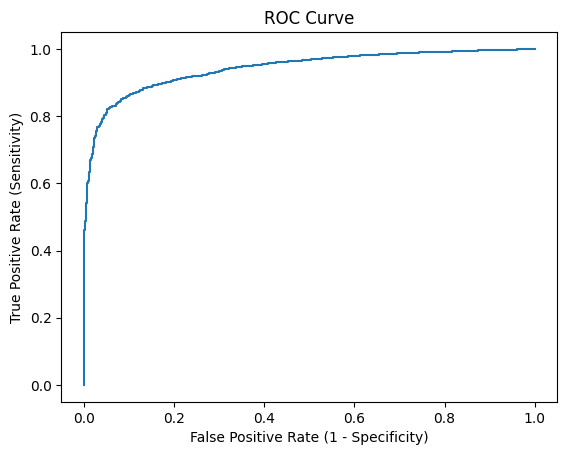

In [5]:
# RoC curve 
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

Y_scores = cross_val_predict(model, X, Y, cv=10, method='decision_function')
fpr, tpr, thresholds = roc_curve(Y, Y_scores)

model = LogisticRegression()
model.fit(X_train, Y_train)
Y_scores = model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_scores)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.show()

In [6]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

#Y_pred = cross_val_predict(model, X, Y, cv=10)
#tp, fn, fp, tn = confusion_matrix(Y, Y_pred).ravel()

Y_pred = model.predict(X_test)
tp, fn, fp, tn = confusion_matrix(Y_test, Y_pred).ravel()

print("True positives: ", tp)
print("False negatives: ", fn)
print("False positives: ", fp)
print("True negatives: ", tn)

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print("Precision: ", precision)
print("Recall: ", recall)

True positives:  334
False negatives:  411
False positives:  152
True negatives:  5691
Precision:  0.6872427983539094
Recall:  0.4483221476510067


In [7]:
confusion_matrix(Y_test, Y_pred)

array([[ 334,  411],
       [ 152, 5691]], dtype=int64)

As can be seen very clearly, although the model has high accuracy and AuC (because of the large number of negative samples), both the precision and recall scores are not high enough. Especially, we want a high recall score (higher ability to capture all the instances of positive)

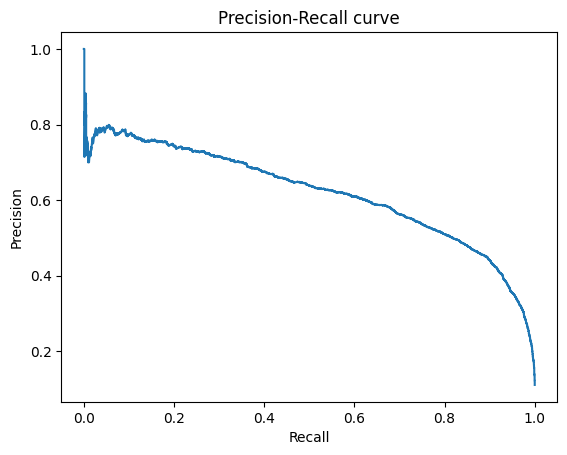

In [8]:
# Precision-Recall curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

Y_scores = cross_val_predict(model, X, Y, cv=10, method='predict_proba')
precisions, recalls, thresholds = precision_recall_curve(Y, Y_scores[:, 0], pos_label=0)

#Y_scores = model.predict_proba(X_test)[:, 0]
#precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_scores, pos_label=0)

plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve') 
plt.show()

Although it was not clear from the AUC and ROC curve (due to small number of positive instances), but the precision-recall curve gives a clearer picture why the classifier is not a good classifier. The precision is drastically decreasing if we aim for a good recall which we are trying to get. So, the target would be to get as higher AUPRC (Area under Precision Recall Curve)

In [9]:
from sklearn.metrics import auc 

AUPRC = auc(recalls, precisions)

print("AUPRC: ", AUPRC)

AUPRC:  0.6192059714226329


# Evaluation metric function

In [10]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import os

def evaluation_metrics(Y, Y_pred, Y_prob, save_plots_dir=None):
    tp, fn, fp, tn = confusion_matrix(Y, Y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + fn + fp + tn)
    AUC = roc_auc_score(Y, Y_prob[:, 1])
    
    print("||>> Precision: ", precision)
    print("||>> Recall: ", recall)
    print("||>> F1: ", f1)
    print("||>> Accuracy: ", accuracy)
    print("||>> AUC: ", AUC)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(Y, Y_prob[:, 1])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    if save_plots_dir:
        plt.savefig(os.path.join(save_plots_dir, 'roc_curve.png'))
    else:
        plt.show()
    
    # Precision-Recall curve
    precisions, recalls, thresholds = precision_recall_curve(Y, Y_prob[:, 0], pos_label=0)
    plt.cla()
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve') 
    if save_plots_dir:
        plt.savefig(os.path.join(save_plots_dir, 'precision_recall_curve.png'))
    else:
        plt.show()
    
    AUPRC = auc(recalls, precisions)
    print("||>> AUPRC: ", AUPRC)
    
    return precision, recall, f1, accuracy, AUC, AUPRC

||>> Precision:  0.656969696969697
||>> Recall:  0.44329334787350055
||>> F1:  0.5293830376037766
||>> Accuracy:  0.912234365513054
||>> AUC:  0.9382859945882682


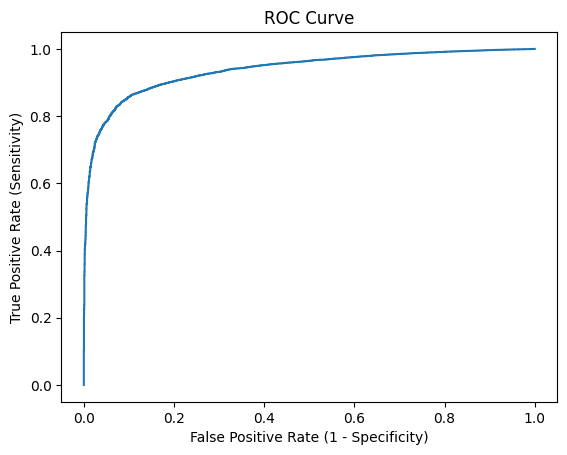

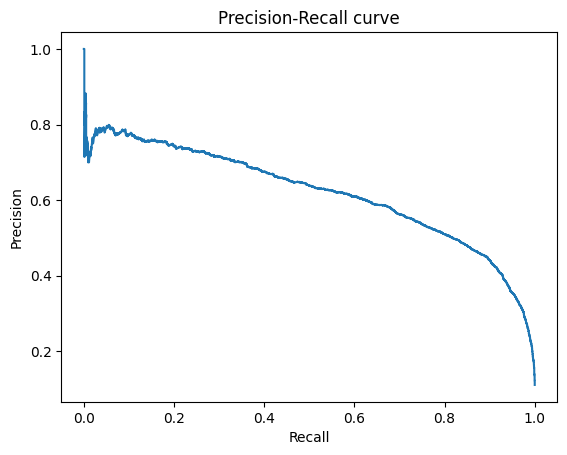

||>> AUPRC:  0.6192059714226329


(0.656969696969697,
 0.44329334787350055,
 0.5293830376037766,
 0.912234365513054,
 0.9382859945882682,
 0.6192059714226329)

In [11]:
from sklearn.model_selection import cross_val_predict

model = LogisticRegression()

Y_pred = cross_val_predict(model, X, Y, cv=10)
Y_prob = cross_val_predict(model, X, Y, cv=10, method='predict_proba')

evaluation_metrics(Y, Y_pred, Y_prob)

# Save Model Function

In [12]:
import joblib

def save_model_and_performance(model, X, Y, model_name):
    model_dir = os.path.join('../mount/trained_models', model_name)
    os.makedirs(model_dir)
    joblib.dump(model, os.path.join(model_dir, 'model.pkl'))
    
    Y_pred = cross_val_predict(model, X, Y, cv=10)
    Y_prob = cross_val_predict(model, X, Y, cv=10, method='predict_proba')
    
    precision, recall, f1, accuracy, AUC, AUPRC = evaluation_metrics(Y, Y_pred, Y_prob, save_plots_dir=model_dir)
    with open(os.path.join(model_dir, 'metrics.txt'), 'w') as f:
        f.write("Precision: {}\n".format(precision))
        f.write("Recall: {}\n".format(recall))
        f.write("F1: {}\n".format(f1))
        f.write("Accuracy: {}\n".format(accuracy))
        f.write("AUC: {}\n".format(AUC))
        f.write("AUPRC: {}\n".format(AUPRC))

In [13]:
save_model_and_performance(model, X, Y, 'logistic_regression')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '../mount/trained_models\\logistic_regression'

In [106]:
model = joblib.load('../mount/trained_models/logistic_regression/model.pkl')

model.predict(X[:10])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

# Decision Trees

In [14]:
from sklearn.tree import DecisionTreeClassifier 

model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

train_score = model.score(X_train, Y_train)
test_score = model.score(X_test, Y_test) 

print("Train accuracy: ", train_score)
print("Test accuracy: ", test_score)

Train accuracy:  1.0
Test accuracy:  0.8902550091074681


In [15]:
model.tree_.n_leaves, model.tree_.max_depth

(1904, 28)

In [16]:
model.feature_importances_

array([0.34004702, 0.03797053, 0.02200157, 0.00699451, 0.07951357,
       0.00907825, 0.07314406, 0.00328027, 0.15563348, 0.02269142,
       0.01588432, 0.0064347 , 0.0047248 , 0.00318582, 0.00757603,
       0.00405242, 0.00491474, 0.00531167, 0.0012436 , 0.00754829,
       0.00257673, 0.00254434, 0.00668377, 0.0060876 , 0.00790463,
       0.00091334, 0.00531319, 0.00533154, 0.00836241, 0.0124092 ,
       0.00063313, 0.00940347, 0.00756029, 0.00390245, 0.00815857,
       0.0010474 , 0.00859751, 0.00399651, 0.00044024, 0.00731182,
       0.00345252, 0.00312768, 0.00172569, 0.00051951, 0.00047608,
       0.00213994, 0.00110775, 0.00082836, 0.00070539, 0.00240975,
       0.00768408, 0.00170574, 0.0075776 , 0.00802987, 0.01035329,
       0.00672426, 0.00962802, 0.00323701, 0.00330779, 0.00485044])

||>> Precision:  0.5013020833333334
||>> Recall:  0.5167785234899329
||>> F1:  0.5089226701916723
||>> Accuracy:  0.8872191863995142
||>> AUC:  0.7206602979300648
||>> AUPRC:  0.5289271474661414


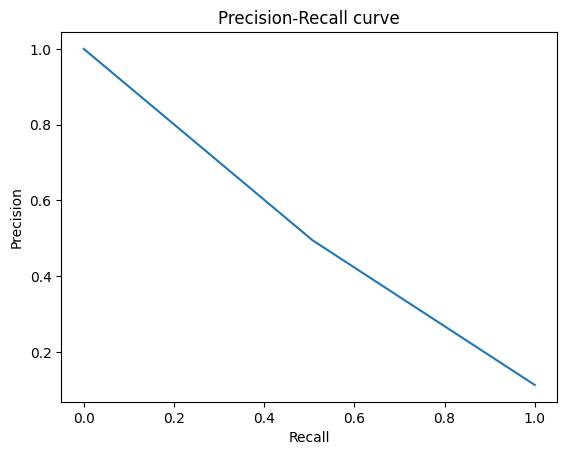

In [18]:
save_model_and_performance(model, X_test, Y_test, 'decision_tree')

It is quite apparent that decision tree is getting overfitted with the given dataset. In cross validation done below, all the metrics are performing worse than the logistic regression. Also the PR curve is almost like a random classifier

||>> Precision:  0.506993006993007
||>> Recall:  0.5139040348964014
||>> F1:  0.5104251286217167
||>> Accuracy:  0.8902246508803886
||>> AUC:  0.7228982002519593


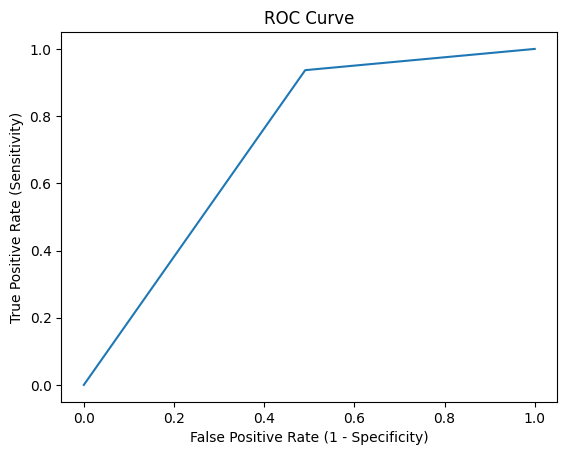

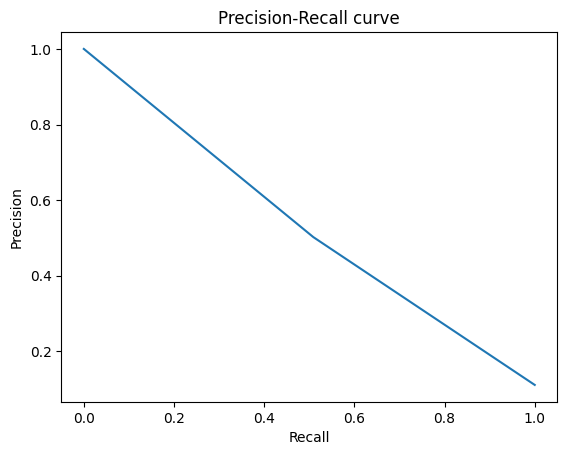

||>> AUPRC:  0.5329793429275049


In [19]:
from sklearn.model_selection import cross_val_predict

model = DecisionTreeClassifier()

Y_pred = cross_val_predict(model, X, Y, cv=10)
Y_prob = cross_val_predict(model, X, Y, cv=10, method='predict_proba')

_ = evaluation_metrics(Y, Y_pred, Y_prob)

# Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, Y_train)
train_score = model.score(X_train, Y_train)

valid_score = model.score(X_test, Y_test)

print("Train accuracy: ", train_score)
print("Test accuracy: ", valid_score)

Train accuracy:  1.0
Test accuracy:  0.9131754705525197


||>> Precision:  0.6576200417536534
||>> Recall:  0.4228187919463087
||>> F1:  0.5147058823529411
||>> Accuracy:  0.9098360655737705
||>> AUC:  0.9343356991156744
||>> AUPRC:  0.6229176970243182


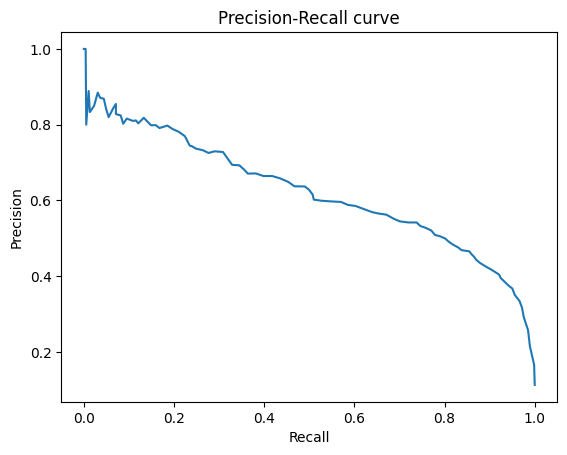

In [21]:
save_model_and_performance(model, X_test, Y_test, 'random_forest_classifier')

The Random Forest Classifier's performance is marginally better than Logistic regression model

||>> Precision:  0.6571861964353432
||>> Recall:  0.47246455834242096
||>> F1:  0.5497224425059476
||>> Accuracy:  0.91381299332119
||>> AUC:  0.9395655362570833


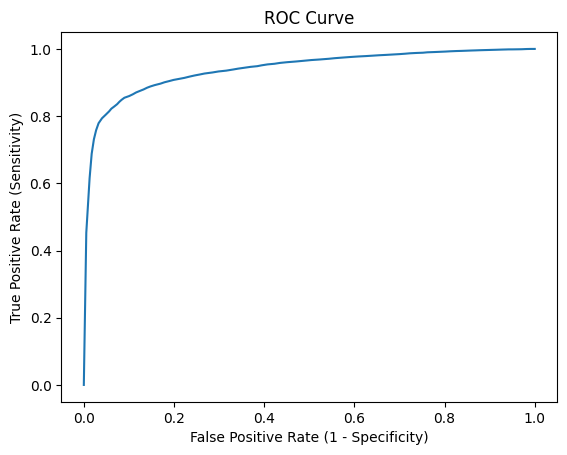

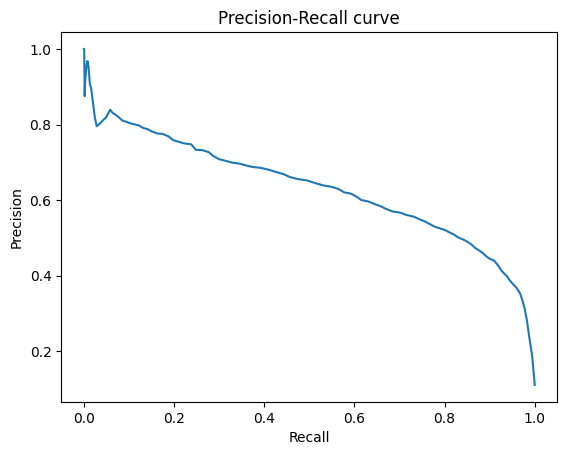

||>> AUPRC:  0.6329292263127085


In [22]:
from sklearn.model_selection import cross_val_predict

Y_pred = cross_val_predict(RandomForestClassifier(), X, Y, cv=5)
Y_prob = cross_val_predict(RandomForestClassifier(), X, Y, cv=5, method='predict_proba')

_ = evaluation_metrics(Y, Y_pred, Y_prob)

# XGBoost Classifier

In [26]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_train, Y_train)

train_score = model.score(X_train, Y_train)
val_score = model.score(X_test, Y_test)

print("Train accuracy: ", train_score)
print("Test accuracy: ", val_score)

Train accuracy:  0.9668715846994536
Test accuracy:  0.9153005464480874


||>> Precision:  0.6084905660377359
||>> Recall:  0.5194630872483221
||>> F1:  0.5604634322954382
||>> Accuracy:  0.9078627808136005
||>> AUC:  0.9351117094165334
||>> AUPRC:  0.6195725679242132


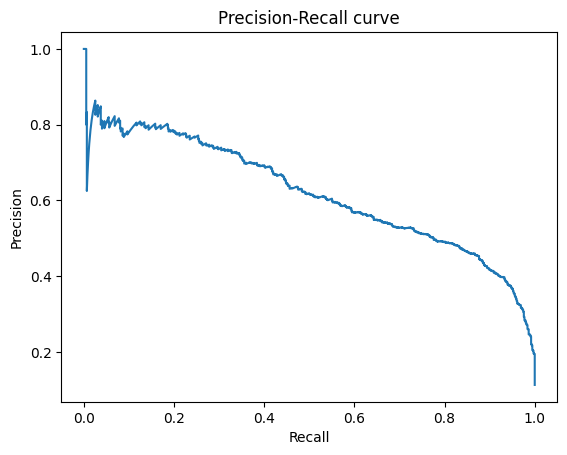

In [28]:
save_model_and_performance(model, X_test, Y_test, 'xgboost_classifier')

XGBoost classifier has performance comparable to random forest

||>> Precision:  0.6336025848142165
||>> Recall:  0.5346237731733915
||>> F1:  0.5799201537779092
||>> Accuracy:  0.913752276867031
||>> AUC:  0.9458396389610715


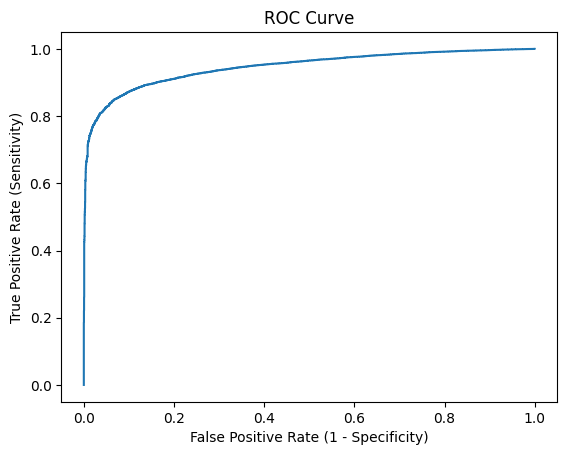

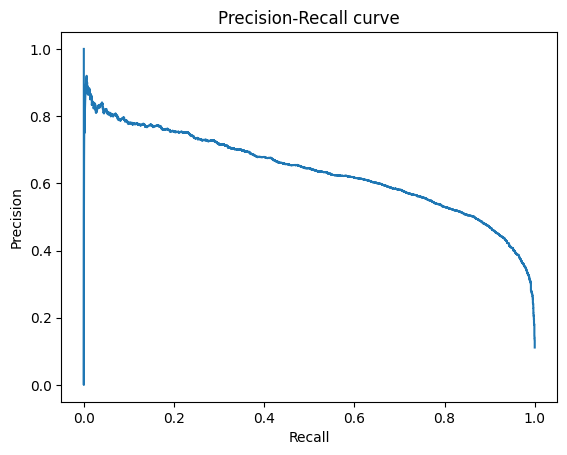

||>> AUPRC:  0.6360811192846303


In [29]:
from sklearn.model_selection import cross_val_predict

Y_pred = cross_val_predict(xgb.XGBClassifier(), X, Y, cv=10)
Y_prob = cross_val_predict(xgb.XGBClassifier(), X, Y, cv=10, method='predict_proba')

_ = evaluation_metrics(Y, Y_pred, Y_prob)